In [1]:
import nbimport
from Aircraft_Kinematics import body_b, body_w, frame_i, frame_b, frame_w, bke, t, m, point_cm_w, \
    V_T, alpha, beta, sol_rot, sol_euler_rates, sol_vel_wind, P, Q, R, phi, theta, psi, M_bx, M_by, M_bz, \
    point_cm_b, M_wx, M_wy, M_wz, J_x, J_y, J_z, J_xz
import sympy
import scipy.optimize
import statespace
import pylab as pl
import control
g, L, C, D, T = sympy.symbols('g, L, C, D, T')
ail, elv, rdr, thr = sympy.symbols('ail, elv, rdr, thr')
%load_ext autoreload
%autoreload 2

importing IPython notebook from Aircraft Kinematics.ipynb


In [2]:
F = m*g*frame_i.z - L(t)*frame_w.z - C(t)*frame_w.y - D(t)*frame_w.x + T(t)*frame_b.x
F

g⋅m i_z - D w_x - C w_y - L w_z + T b_x

In [3]:
di_L_i = bke(body_w.linear_momentum(frame_i), frame_i, frame_w, t) 
sol_trans = sympy.solve((di_L_i - F).to_matrix(frame_w), [xi(t).diff(t) for xi in [V_T, alpha, beta]])
sol_trans

⎧                                                                             
⎨V_̇T: g⋅sin(α)⋅cos(φ)⋅cos(θ) + g⋅sin(β)⋅sin(φ)⋅cos(α)⋅cos(θ) - g⋅sin(θ)⋅cos(α
⎩                                                                             

           D   T⋅cos(α)⋅cos(β)      -g⋅m⋅sin(α)⋅sin(β)⋅sin(φ)⋅cos(θ) + g⋅m⋅sin
)⋅cos(β) - ─ + ───────────────, α̇: ──────────────────────────────────────────
           m          m                                                       

(α)⋅sin(θ)⋅cos(β) + g⋅m⋅cos(α)⋅cos(φ)⋅cos(θ) - m⋅P⋅V_T⋅sin(β) + m⋅Q⋅V_T⋅cos(β)
──────────────────────────────────────────────────────────────────────────────
                          m⋅V_T                                               

 - L - T⋅sin(α)⋅cos(β)      g⋅m⋅sin(β)⋅sin(θ) + g⋅m⋅sin(φ)⋅cos(β)⋅cos(θ) + m⋅P
──────────────────────, β̇: ──────────────────────────────────────────────────
                                                                              

⋅V_T⋅sin(α)⋅cos(β) + m⋅Q⋅V_T⋅sin(α)⋅sin(β) - m⋅R

In [4]:
M = frame_w.x*M_wx(t) + frame_w.y*M_wy(t) + frame_w.z*M_wz(t)

In [5]:
di_H_i = bke(body_b.angular_momentum(point_cm_b, frame_i), frame_i, frame_b, t)
di_H_i

(Jₓ⋅Ṗ + J_xz⋅Ṙ - J_y⋅Q⋅R + (J_xz⋅P + J_z⋅R)⋅Q) b_x + (J_y⋅Q̇ + (Jₓ⋅P + J_xz⋅R)⋅R - (J_xz⋅P + J_z⋅R)⋅P) b_y + (J_xz⋅Ṗ + J_y⋅P⋅Q + J_z⋅Ṙ - (Jₓ⋅P + J_xz⋅R)⋅Q) b_z

In [6]:
sol_rot = sympy.solve((M - di_H_i).to_matrix(frame_b), [xi(t).diff(t) for xi in [P, Q, R]])
sol_rot

⎧                                                                             
⎪    -(J_xz⋅(Jₓ⋅P⋅Q + J_xz⋅Q⋅R - J_y⋅P⋅Q + M_wx⋅sin(α) + M_wz⋅cos(α)) + J_z⋅(J
⎨Ṗ: ─────────────────────────────────────────────────────────────────────────
⎪                                                                             
⎩                                                                             

                                                                              
_xz⋅P⋅Q - J_y⋅Q⋅R + J_z⋅Q⋅R - M_wx⋅cos(α)⋅cos(β) + M_wy⋅sin(β) + M_wz⋅sin(α)⋅c
──────────────────────────────────────────────────────────────────────────────
             2                                                                
Jₓ⋅J_z - J_xz                                                                 

                              2         2                                     
os(β)))       -Jₓ⋅P⋅R + J_xz⋅P  - J_xz⋅R  + J_z⋅P⋅R + M_wx⋅sin(β)⋅cos(α) + M_w
────────, Q̇: ────────────────────────────────────

In [7]:
eoms = {}
eoms.update(sol_euler_rates)
eoms.update(sol_trans)
eoms.update(sol_vel_wind)
eoms.update(sol_rot)

x_vect = sympy.Matrix([Q, theta, V_T, alpha, P, R, phi, beta])
u_vect = sympy.Matrix([elv, thr, ail, rdr])
sub_no_t = {xi(t): xi for xi in x_vect}
f_vect = sympy.Matrix([eoms[xi(t).diff(t)].subs(sub_no_t) for xi in x_vect])
f_vect

⎡                                                 2         2                 
⎢                                 -Jₓ⋅P⋅R + J_xz⋅P  - J_xz⋅R  + J_z⋅P⋅R + M_wx
⎢                                 ────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                      Q⋅cos(φ
⎢                                                                             
⎢                                                                             
⎢                             g⋅sin(α)⋅cos(φ)⋅cos(θ) + g⋅sin(β)⋅sin(φ)⋅cos(α)⋅
⎢                                                                             
⎢                                                                             
⎢        -P⋅V_T⋅m⋅sin(β) + Q⋅V_T⋅m⋅cos(β) - g⋅m⋅sin(α)⋅sin(β)⋅sin(φ)⋅cos(θ) + 
⎢        ───────────────────────────────────────────

In [8]:
C_L_0, C_L_alpha, k_CD_CL, C_D_0, CL_CD_min, rho, S = \
sympy.symbols('C_L0 C_L_alpha k_CD_CL C_D_0 CL_CD_min, rho, S')
C_L = C_L_0 + C_L_alpha*alpha
C_D = C_D_0 + k_CD_CL*(C_L - CL_CD_min)**2
C_C = beta # todo
C_T = 10
C_l = -beta + ail
C_m = -alpha + elv
C_n = -beta + rdr
q = rho*V_T**2/2
sub_aero_model = {
    L(t): C_L*q*S,
    D(t): C_D*q*S,
    C(t): C_C*q*S,
    T(t): C_T*thr,
    M_wx(t): C_l*q*S,# todo
    M_wy(t): C_m*q*S,# todo
    M_wz(t): C_n*q*S,# todo
}
sub_aero_model

⎧        2              2   ⎛                                             2⎞  
⎪   S⋅V_T ⋅β⋅ρ     S⋅V_T ⋅ρ⋅⎝C_D_0 + k_CD_CL⋅(-CL_CD_min + C_L0 + C_L_α⋅α) ⎠  
⎨C: ──────────, D: ─────────────────────────────────────────────────────────, 
⎪       2                                      2                              
⎩                                                                             

        2                                2                         2          
   S⋅V_T ⋅ρ⋅(C_L0 + C_L_α⋅α)        S⋅V_T ⋅ρ⋅(ail - β)        S⋅V_T ⋅ρ⋅(-α + e
L: ─────────────────────────, M_wx: ──────────────────, M_wy: ────────────────
               2                            2                          2      
                                                                              

                2                        ⎫
lv)        S⋅V_T ⋅ρ⋅(-β + rdr)           ⎪
───, M_wz: ───────────────────, T: 10⋅thr⎬
                    2                    ⎪
                                    

In [9]:
f_aero_vect = f_vect.subs(sub_aero_model).applyfunc(lambda e:e.simplify())
f_aero_vect

⎡                                                                             
⎢                                                                    2        
⎢                                                    -Jₓ⋅P⋅R + J_xz⋅P  - J_xz⋅
⎢                                                                             
⎢                                                    ─────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                             2   ⎛                           
⎢                                        S⋅V_T ⋅ρ⋅⎝C_D_0 + k_CD_CL⋅(-CL_CD_min
⎢                                      - ─────────────────────────────────────
⎢                                                   

In [10]:
param = f_aero_vect.atoms(sympy.Symbol).difference(x_vect)
param

set([CL_CD_min, C_D_0, C_L0, C_L_α, Jₓ, J_xz, J_y, J_z, S, ail, elv, g, k_CD_C
L, m, rdr, ρ, thr])

In [11]:
#x_id = sympy.Matrix(list(x_vect) + list(param))
#f_id_vect = sympy.Matrix(list(f_aero_vect) + list(sympy.zeros(len(param))))
#A_id = f_id_vect.jacobian(x_id)
#sub_x0 = {P:0, Q:0, R:0, phi:0, theta:0, alpha:0, beta:0}
#A_id.subs(sub_x0)

In [12]:
sub_const = {
    J_x:1, J_y:1, J_z:1, J_xz:0, m:1, rho:1.225, S:1, g:10,
    C_L_alpha:0.1, C_L_0: 0.1, C_D_0: 0.01, k_CD_CL: 0.01, CL_CD_min:0,
}

In [13]:
x_vect.T, u_vect.T

([Q  θ  V_T  α  P  R  φ  β], [elv  thr  ail  rdr])

In [14]:
def trim_level(V_T, gamma):
    f1 = lambda theta, elv, thr: \
        pl.sum(ss.f_eval(0, [0, theta, V_T, gamma-theta, 0, 0, 0, 0], [elv, thr, 0, 0])**2)
    res = scipy.optimize.minimize(lambda x:f1(theta=x[0], elv=x[1], thr=x[2]), [0,0,0])
    theta_trim = res.x[0]
    elv_trim = res.x[1]
    thr_trim = res.x[2]
    return [0, theta_trim, V_T, gamma - theta_trim, 0, 0, 0, 0], [elv_trim, thr_trim, 0, 0], res

([0, -0.567366465478, 10, 0.567366465478, 0, 0, 0, 0], [0.56736645304, -1.0004
1212586, 0, 0])

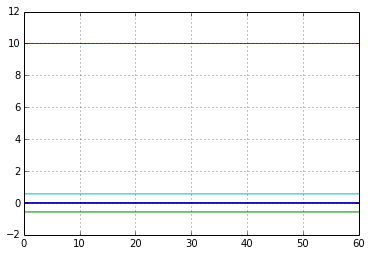

In [15]:
ss = statespace.StateSpace(x_vect, u_vect, f_aero_vect.subs(sub_const), x_vect)
x0, u0, res = trim_level(10, 0)
data = ss.simulate(x0, u0,dt=0.01,tf=60)
pl.plot(data.t, data.y);
pl.grid()
x0, u0

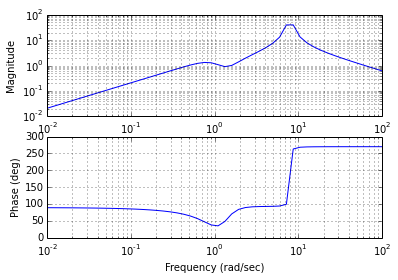

In [69]:
ss_lin = ss.linearize()
ss0 = control.ss(*ss_lin.eval(x0, u0))
control.bode(ss0[0,0], omega=pl.logspace(-2,2));

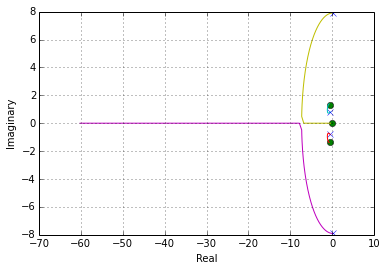

In [70]:
control.rlocus(ss0[0,0], klist=pl.linspace(0,1,1000));
pl.grid()

In [71]:
ss_lin.A

⎡                                                                             
⎢      0                                                 0                    
⎢                                                                             
⎢   cos(φ)                                               0                    
⎢                                                                             
⎢                                                                             
⎢      0        -10⋅sin(α)⋅sin(θ)⋅cos(φ) - 10⋅sin(β)⋅sin(φ)⋅sin(θ)⋅cos(α) - 10
⎢                                                                             
⎢                                                                             
⎢               10⋅sin(α)⋅sin(β)⋅sin(φ)⋅sin(θ) + 10⋅sin(α)⋅cos(β)⋅cos(θ) - 10⋅
⎢   cos(β)      ──────────────────────────────────────────────────────────────
⎢                                                      V_T                    
⎢                                                   

In [80]:
print ss_lin.f.subs(sympy.MatrixSymbol('u_0', 4, 1), sympy.Matrix([1,2,3,4]))

Matrix([
[ 0.6125*V_T**2*cos(beta),                              0, 0.6125*V_T**2*sin(beta)*cos(alpha), -0.6125*V_T**2*sin(alpha)*sin(beta)],
[                       0,                              0,                                  0,                                   0],
[                       0,        10*cos(alpha)*cos(beta),                                  0,                                   0],
[                       0,   -10*sin(alpha)*cos(beta)/V_T,                                  0,                                   0],
[-0.6125*V_T**2*sin(beta),                              0, 0.6125*V_T**2*cos(alpha)*cos(beta), -0.6125*V_T**2*sin(alpha)*cos(beta)],
[                       0,                              0,           0.6125*V_T**2*sin(alpha),            0.6125*V_T**2*cos(alpha)],
[                       0,                              0,                                  0,                                   0],
[                       0, -10*sin(beta)/(V_T*cos(alpha)),  

In [76]:
ss_lin.f.subs(sympy.Matrix('u_0', 4, 1), [1,2,3,4])

ValueError: invalid literal for int() with base 10: 'u_0'

In [72]:
data_lin = ss_lin.simulate(pl.zeros(8), pl.zeros(4))


NameError: global name 'x_0' is not defined

In [63]:
data_lin = ss_lin.simulate(pl.zeros(8), pl.zeros(4))
#data = ss.simulate(x0, u0)
#pl.plot(data.t, data.x);
#pl.plot(data.t, data_lin.x);

KeyboardInterrupt: 